# Environment

In [1]:
import os
from environs import Env

env = Env()
env.read_env(".env") # read .env file, if it exists

True

In [2]:
from openai import OpenAI
import json
import pandas as pd
import matplotlib.pyplot as plt

# Get the Data

In [3]:
df = pd.read_csv('../data/twitter_validation.csv', names=['id', 'site', 'label', 'tweet'], header=None)
df.head()

,id,site,label,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [4]:
df = df[['tweet']]
df.head()

,tweet
0,I mentioned on Facebook that I was struggling ...
1,BBC News - Amazon boss Jeff Bezos rejects clai...
2,@Microsoft Why do I pay for WORD when it funct...
3,"CSGO matchmaking is so full of closet hacking,..."
4,Now the President is slapping Americans in the...


In [5]:
sample_df = df.sample(25)                              # the sampled df with only 25 tweets

# OpenAI / Prompt Engineering

In [6]:
client = OpenAI()

In [7]:
# List values of the 'tweet' column
tweets = sample_df['tweet'].tolist()

print(tweets)

['@Rainbow6Game when will you ban mnk/cronos players on console? The game will die on ps/xbox because of that cheater. 😭', "This is really interesting for indie RPGs with character portraits for NPCs. A game like The Age of Decadence has dozens of custom portraits, and those cost at least 150 dollars each, likely twice that, so it's a big price to pay for small teams.", 'Man nothing makes me feel dumber than trying to play hearthstone', "Red Dead Redemption 2 [Day 8] Can I shoot Micah? I don't like Micah. twitch.tv/nightmarebearer", 'The Russians from cs:go are starting to invade Osu...', 'My advice when you suck like me \n#Fortnite\n#streamers\n#Budget2020\nvm.tiktok.com/ZMJfQKRPy/', 'Dusty depot 😌😌', "Yo! @Verizon just added a $120 'fee' to my account under #COVID19 protection without my permission and I am forced to pay it! Check your bills carefully!", 'Best trailers this decade\n\n1)CS GO\n2)Baahubali 2\n3) The Dark Knight Rises', 'I want to thank #SSKYWILDKATSSS for letting me ru

In [8]:
list_responses = []
for tweet in tweets:
    response = client.chat.completions.create(
      model="gpt-3.5-turbo-1106",
      response_format={ "type": "json_object" },
      messages=[
        {"role": "system", "content": 'You are a helpful assistant that categorizes tweets into sentiment and tone. Use "Positive", "Negative", or "Neutral" for sentiment. For each tweet, please state the sentiment, tone, and the tweet. Use the json format for the response.'},
        {"role": "user", "content": tweet}
      ]
    )
    
    generated_content = response.choices[0].message.content
    
    list_responses.append(generated_content)

# Storing the results into a dataframe

In [9]:
# Convert the list of JSON objects to a JSON-formatted string
json_string_responses = json.dumps(list_responses, indent=4)  # indent parameter for pretty formatting (optional)

# Print or use the JSON-formatted string as needed
print(json_string_responses)

[
    "{\n  \"sentiment\": \"Negative\",\n  \"tone\": \"Frustrated\",\n  \"tweet\": \"@Rainbow6Game when will you ban mnk/cronos players on console? The game will die on ps/xbox because of that cheater. \ud83d\ude2d\"\n}",
    "{\n  \"sentiment\": \"Negative\",\n  \"tone\": \"Neutral\",\n  \"tweet\": \"This is really interesting for indie RPGs with character portraits for NPCs. A game like The Age of Decadence has dozens of custom portraits, and those cost at least 150 dollars each, likely twice that, so it's a big price to pay for small teams.\"\n}",
    "{\n  \"sentiment\": \"Negative\",\n  \"tone\": \"Frustration\",\n  \"tweet\": \"Man nothing makes me feel dumber than trying to play hearthstone\"\n}",
    "{\n  \"sentiment\": \"Negative\",\n  \"tone\": \"Negative\",\n  \"tweet\": \"Red Dead Redemption 2 [Day 8] Can I shoot Micah? I don't like Micah. twitch.tv/nightmarebearer\"\n}",
    "{\n  \"sentiment\": \"Negative\",\n  \"tone\": \"Concerned\",\n  \"tweet\": \"The Russians from 

In [10]:
# Load the JSON array as a list
json_list_responses = json.loads(json_string_responses)

# Print or use the resulting list
print(type(json_list_responses))

<class 'list'>


In [11]:
# Convert JSON strings to Python dictionaries
parsed_data = [json.loads(item) for item in json_list_responses]

# Create DataFrame with columns "sentiment," "tone," and "tweet"
result_df = pd.json_normalize(parsed_data)
result_df

,sentiment,tone,tweet,tweets
0,Negative,Frustrated,@Rainbow6Game when will you ban mnk/cronos pla...,NaN
1,Negative,Neutral,This is really interesting for indie RPGs with...,NaN
2,Negative,Frustration,Man nothing makes me feel dumber than trying t...,NaN
3,Negative,Negative,Red Dead Redemption 2 [Day 8] Can I shoot Mica...,NaN
4,Negative,Concerned,The Russians from cs:go are starting to invade...,NaN
5,Neutral,Informative,My advice when you suck like me #Fortnite #str...,NaN
6,Positive,Relaxed,Dusty depot 😌😌,NaN
7,Negative,Angry,Yo! @Verizon just added a $120 'fee' to my acc...,NaN
8,NaN,NaN,NaN,"[{'sentiment': 'Positive', 'tone': 'Neutral', ..."
9,Positive,Grateful,I want to thank #SSKYWILDKATSSS for letting me...,NaN


# Save results

In [12]:
result_df.to_csv('../data/result.csv', index=False)

# Visualization

In [13]:
positive_df = result_df[result_df["sentiment"]=="Positive"]
negative_df = result_df[result_df["sentiment"]=="Negative"]
neutral_df = result_df[result_df["sentiment"]=="Neutral"]

([<matplotlib.patches.Wedge at 0x1697ad9c760>,
 [Text(0.2847009827728237, 1.0625184000327659, 'Negative'),
  Text(-1.0162675251747608, -0.42095168045176784, 'Neutral'),
  Text(0.6696374357312337, -0.8726887788136719, 'Positive')],
 [Text(0.1552914451488129, 0.5795554909269631, '41.7%\n10'),
  Text(-0.5543277410044148, -0.22961000751914606, '29.2%\n7'),
  Text(0.36525678312612747, -0.47601206117109374, '29.2%\n7')])

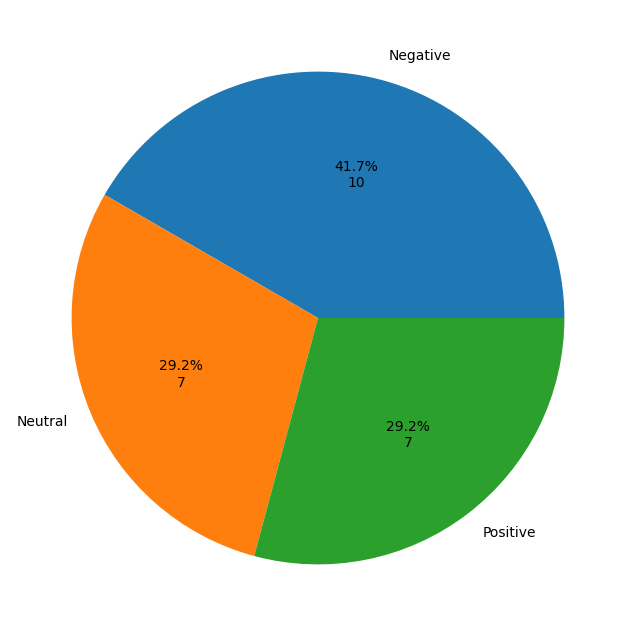

In [14]:
# https://stackoverflow.com/questions/73616867/pie-chart-from-count-of-values-showing-the-percentage
total = result_df['sentiment'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)
plt.figure(figsize=(10,8))
plt.pie(result_df['sentiment'].value_counts().values, labels=result_df['sentiment'].value_counts().index, autopct=fmt)

Text(0.5, 1.0, 'Positive Sentiment')

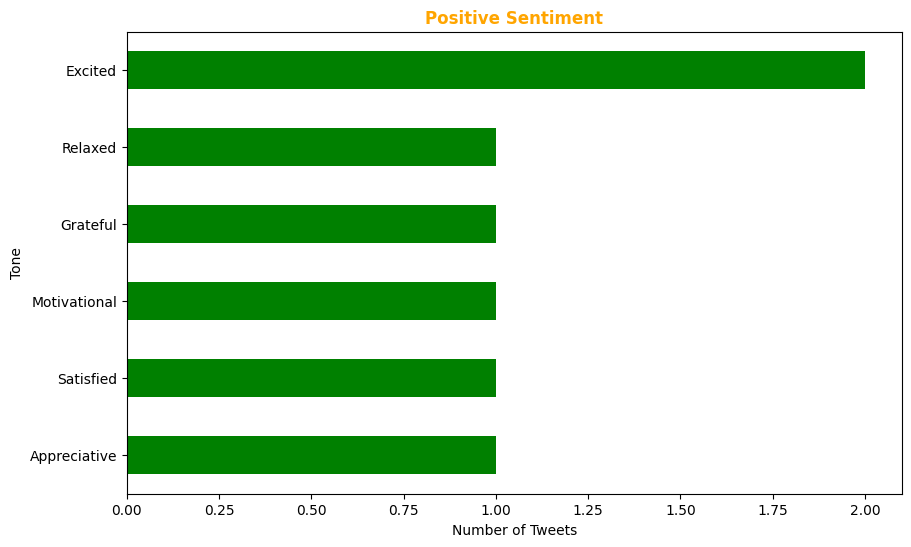

In [15]:
positive_df['tone'].value_counts().plot(kind='barh', figsize=(10,6), color="green").invert_yaxis()
plt.ylabel('Tone')
plt.xlabel('Number of Tweets')
plt.title("Positive Sentiment", fontweight='bold', color = 'orange', fontsize='12', horizontalalignment='center')

Text(0.5, 1.0, 'Negative Sentiment')

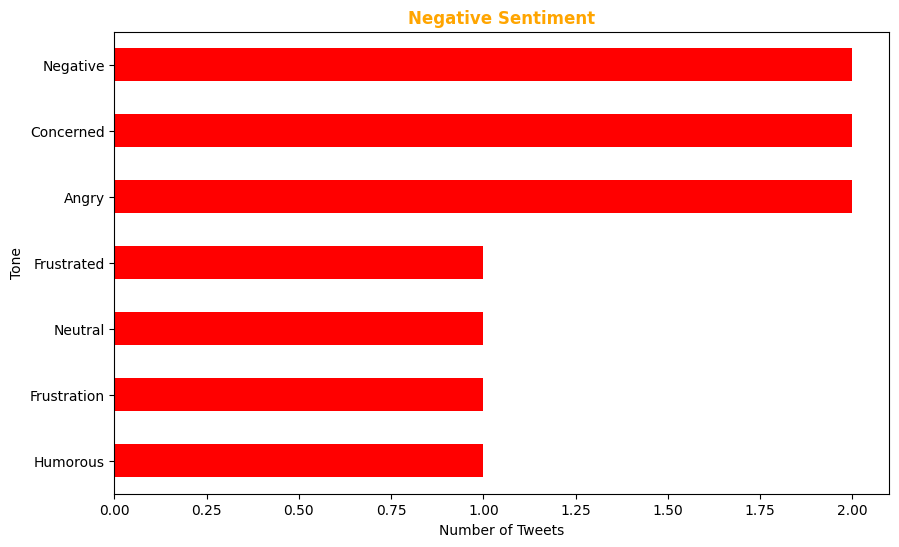

In [16]:
negative_df['tone'].value_counts().plot(kind='barh', figsize=(10,6), color="red").invert_yaxis()
plt.ylabel('Tone')
plt.xlabel('Number of Tweets')
plt.title("Negative Sentiment", fontweight='bold', color = 'orange', fontsize='12', horizontalalignment='center')

Text(0.5, 1.0, 'Neutral Sentiment')

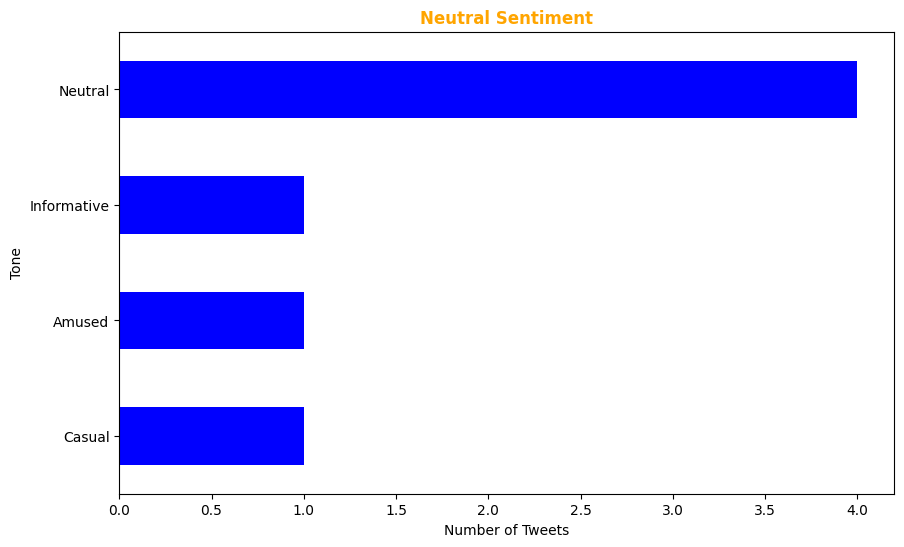

In [17]:
neutral_df['tone'].value_counts().plot(kind='barh', figsize=(10,6), color="blue").invert_yaxis()
plt.ylabel('Tone')
plt.xlabel('Number of Tweets')
plt.title("Neutral Sentiment", fontweight='bold', color = 'orange', fontsize='12', horizontalalignment='center')